In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from scipy.linalg import cholesky
from numpy.linalg import eig, norm

# Problem 1

In [2]:
# Get the returns data, excluding the SPY column
file_path = 'DailyReturn.csv'
df = pd.read_csv(file_path)
data = df.drop(columns=['SPY'])
returns = data.values

In [3]:
# Function to compute the Exponentially Weighted Covariance Matrix (EWCM)
def exp_weighted_cov(returns, lambda_):
    T, N = returns.shape  # T: number of time periods, N: number of assets
    weights = np.array([(1-lambda_)*lambda_**i for i in range(T)])
    weights = weights / weights.sum()  # Normalize the weights
    
    # Mean of the returns weighted by exponential weights
    weighted_mean = np.average(returns, axis=0, weights=weights)
    
    # Compute the weighted covariance matrix
    cov_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(i, N):
            cov_ij = np.sum(weights * (returns[:, i] - weighted_mean[i]) * (returns[:, j] - weighted_mean[j]))
            cov_matrix[i, j] = cov_ij
            cov_matrix[j, i] = cov_ij
    
    return cov_matrix

In [4]:
# Function to perform PCA 
def perform_pca(cov_matrix):
    # Eigenvalue decomposition of the covariance matrix
    vals, vecs = np.linalg.eigh(cov_matrix)
    
    # Sort the eigenvalues in descending order
    vals_sorted_indices = np.argsort(vals)[::-1] 
    vals = vals[vals_sorted_indices]    
    
    # Calculate the explained variance ratio
    total_variance = np.sum(vals)  
    explained_variance = vals / total_variance  
    
    # Calculate cumulative explained variance
    explained_variance_ratio = np.cumsum(explained_variance)  
    
    return explained_variance_ratio

# Function to perform PCA (using package)
# def perform_pca_1(cov_matrix):
#    pca = PCA()
#    pca.fit(cov_matrix)
#    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
#    return explained_variance_ratio

In [5]:
# Function to plot the cumulative variance
def plot_cumulative_variance(explained_variance_ratio, lambda_):
    plt.plot(explained_variance_ratio, label=f'λ={lambda_}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.legend()

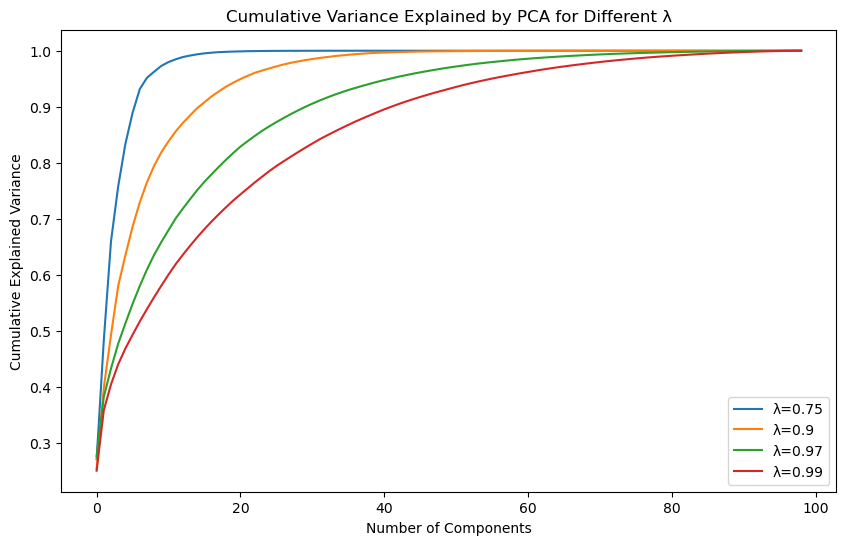

In [6]:
# List of λ values to test
lambda_values = [0.75, 0.90, 0.97, 0.99]

# Loop through each lambda value and compute EWCM and PCA, then plot the results
plt.figure(figsize=(10, 6))
for lambda_ in lambda_values:
    ew_cov_matrix = exp_weighted_cov(returns, lambda_)
    explained_variance_ratio = perform_pca(ew_cov_matrix)
    plot_cumulative_variance(explained_variance_ratio, lambda_)

# Show the final plot
plt.title('Cumulative Variance Explained by PCA for Different λ')
plt.show()

# Problem 2

In [7]:
# Cholesky decomposition that assumes PSD
def chol_psd(a):
    n = a.shape[0]
    root = np.zeros_like(a)
    
    # Loop over columns
    for j in range(n):
        s = 0.0
        # If not on the first column, calculate the dot product of previous row values
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])
        
        # Diagonal element
        temp = a[j, j] - s
        if 0 >= temp >= -1e-8:
            temp = 0.0
        
        root[j, j] = np.sqrt(temp)
        
        # Check for zero eigenvalue, if zero move to the next column
        if root[j, j] != 0.0:
            ir = 1.0 / root[j, j]
            # Update off-diagonal rows of the column
            for i in range(j+1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    
    return root

In [8]:
# Function to find the nearest PSD matrix
def near_psd(a, epsilon=1e-6):
    n = a.shape[0]
    out = a.copy()
    
    # Check if diagonal is all 1s, if not, standardize into a correlation matrix
    if not np.allclose(np.diag(out), 1.0):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD
    
    # Eigenvalue decomposition
    vals, vecs = np.linalg.eigh(out)
    
    # Replace negative eigenvalues with small positive ones (>= epsilon)
    vals = np.maximum(vals, epsilon)
    
    # Rebuild matrix using the modified eigenvalues
    out = vecs @ np.diag(vals) @ vecs.T
    
    # Restore original scaling (if it was scaled)
    if not np.allclose(np.diag(a), 1.0):
        invSD = np.diag(np.sqrt(np.diag(a)))
        out = invSD @ out @ invSD
    
    return out

In [9]:
# Higham's method (nearest PSD)
def higham_nearest_psd(a, tol=1e-8, max_iter=100):
    n = a.shape[0]
    Y = a.copy()
    dS = np.zeros_like(a)
    
    for k in range(max_iter):
        # SVD decomposition of Y
        vals, vecs = np.linalg.eigh(Y)
        vals = np.maximum(vals, 0)
        X = vecs @ np.diag(vals) @ vecs.T
        dS = X - Y
        
        # Frobenius norm between X and A
        norm_diff = norm(dS, ord='fro')
        if norm_diff < tol:
            break
        Y = X
    
    return X

In [10]:
# Function to generate a non-PSD correlation matrix
def generate_non_psd_matrix(n):
    sigma = np.full((n, n), 0.9)
    np.fill_diagonal(sigma, 1.0)
    sigma[0, 1] = 0.7357
    sigma[1, 0] = 0.7357
    return sigma

In [11]:
# Use near_psd() and Higham's method to fix the matrix
psd_near = near_psd(generate_non_psd_matrix(500))
psd_higham = higham_nearest_psd(generate_non_psd_matrix(500))

# Confirm the matrices are now PSD by checking their eigenvalues

# Confirm psd_near is PSD
eigenvalues_near = np.linalg.eigvals(psd_near)
is_psd_near = np.all(eigenvalues_near >= 0)
print(f"Is the matrix from near_psd() PSD? {is_psd_near}")

# Confirm psd_higham is PSD
eigenvalues_higham = np.linalg.eigvals(psd_higham)
is_psd_higham = np.all(eigenvalues_higham >= 0)
print(f"Is the matrix from Higham's method PSD? {is_psd_higham}")

Is the matrix from near_psd() PSD? True
Is the matrix from Higham's method PSD? True


In [12]:
# Compare the results of both methods using the Frobenius norm
def compare_methods(matrix, n):
    print(f"Comparing methods for N={n} with Frobenius norm:")

    # Timing near_psd()
    start_time = time.time()
    psd_near = near_psd(matrix)
    time_near = time.time() - start_time
    print(f"near_psd Frobenius norm: {norm(matrix - psd_near, ord='fro'):.6f}, Time: {time_near:.6f}s")

    # Timing Higham's method
    start_time = time.time()
    psd_higham = higham_nearest_psd(matrix)
    time_higham = time.time() - start_time
    print(f"Higham's method Frobenius norm: {norm(matrix - psd_higham, ord='fro'):.6f}, Time: {time_higham:.6f}s")

In [13]:
# List of N values to test
N_values = [500, 1000, 1500]

# Loop through the values of N and run the comparisons
for n in N_values:
    sigma = generate_non_psd_matrix(n)
    compare_methods(sigma, n)

Comparing methods for N=500 with Frobenius norm:
near_psd Frobenius norm: 0.063644, Time: 0.027349s
Higham's method Frobenius norm: 0.063643, Time: 0.037242s
Comparing methods for N=1000 with Frobenius norm:
near_psd Frobenius norm: 0.063972, Time: 0.126580s
Higham's method Frobenius norm: 0.063971, Time: 0.220852s
Comparing methods for N=1500 with Frobenius norm:
near_psd Frobenius norm: 0.064082, Time: 0.408260s
Higham's method Frobenius norm: 0.064081, Time: 0.831507s


# Problem 3

In [14]:
# Direct simulation from covariance matrix
def direct_simulation(cov_matrix, mean_vector=None, n_sim=25000):
    # Cholesky decomposition of the covariance matrix
    L = np.linalg.cholesky(cov_matrix)  
    
    # Generate standard normal random variables (Z)
    N = cov_matrix.shape[0]  
    Z = np.random.normal(size=(N, n_sim))  
    
    # Mean vector 
    if mean_vector is None:
        mean_vector = np.zeros(N)
    
    # Calculate the random samples
    # Formula: X = (LZ + μ)^T
    X = (L @ Z + mean_vector[:, np.newaxis]).T
    
    return X

# Function to simulate multivariate normal draws using the package
# def direct_simulation(cov_matrix, n_sim=25000):
#    N = cov_matrix.shape[0]
#    mean = np.zeros(N)
#    return np.random.multivariate_normal(mean, cov_matrix, size=n_sim)

In [15]:
# PCA-based simulation 
def pca_simulation(cov_matrix, n_sim=25000, variance_explained=1.0):
    # Eigenvalue decomposition of the covariance matrix
    vals, vecs = np.linalg.eigh(cov_matrix)
    
    # Sort the eigenvalues and eigenvectors in descending order
    flip = np.argsort(vals)[::-1] 
    vals = vals[flip]
    vecs = vecs[:, flip]
    
    # Calculate the cumulative variance explained by the eigenvalues
    total_variance = np.sum(vals)
    cumulative_variance = np.cumsum(vals) / total_variance
    
    # Find the number of components to retain based on the percentage of variance explained
    n_components = np.searchsorted(cumulative_variance, variance_explained) + 1 
    
    # Ensure that the number of components does not exceed the available dimensions
    n_components = min(n_components, len(vals))
    
    # Select the corresponding eigenvalues and eigenvectors for the chosen variance
    vals = vals[:n_components]
    vecs = vecs[:, :n_components]
    
    # Calculate the B matrix (vecs * sqrt of eigenvalues)
    B = vecs @ np.diag(np.sqrt(vals))
    
    # Generate random normal variables and multiply with B
    random_normals = np.random.randn(n_components, n_sim)
    
    # Return the transposed simulated data matrix
    return (B @ random_normals).T

In [16]:
# Calculate Pearson correlation and variance
pearson_corr = data.corr().values  
pearson_var = data.var().values

# Calculate exponentially weighted covariance matrix with lambda = 0.97
ewcm_cov = exp_weighted_cov(returns, lambda_=0.97)

# Calculate EWCM correlation and variance 
ewcm_var = np.diag(ewcm_cov)
ewcm_corr = ewcm_cov / np.outer(ewcm_var, ewcm_var) 

In [17]:
# Generate the four different covariance matrices

# Pearson correlation + Pearson variance
cov_pearson = np.diag(pearson_var) @ pearson_corr @ np.diag(pearson_var)

# Pearson correlation + EWCM variance
cov_pearson_ewcm_var = np.diag(ewcm_var) @ pearson_corr @ np.diag(ewcm_var)

# EWCM correlation + EWCM variance 
cov_ewcm = ewcm_cov

# EWCM correlation + Pearson variance
cov_ewcm_pearson_var = np.diag(pearson_var) @ ewcm_corr @ np.diag(pearson_var)

# Collecting all four covariance matrices
cov_matrices = {
    'Pearson Corr + Pearson Var': cov_pearson,
    'Pearson Corr + EWCM Var': cov_pearson_ewcm_var,
    'EWCM Corr + EWCM Var': cov_ewcm,
    'EWCM Corr + Pearson Var': cov_ewcm_pearson_var
}

In [18]:
# Function to calculate the Frobenius norm
def frobenius_norm(A, B):
    return norm(A - B, ord='fro')

In [19]:
# Function to run simulations and compare results
def compare_simulations(cov_matrix, matrix_name, n_sim=25000):
    print(f"Simulating for {matrix_name}")
    
    # Direct Simulation
    start_time = time.time()
    sim_direct = direct_simulation(cov_matrix, mean_vector=None, n_sim=n_sim)
    direct_time = time.time() - start_time
    sim_cov_direct = np.cov(sim_direct, rowvar=False)
    fn_direct = frobenius_norm(cov_matrix, sim_cov_direct)
    
    print(f"Direct Simulation: Frobenius Norm = {fn_direct:.6f}, Time = {direct_time:.6f}s")
    print("Covariance matrix of simulated values (Direct):")
    print(sim_cov_direct)
    
    # PCA with 100% explained variance
    start_time = time.time()
    sim_pca_100 = pca_simulation(cov_matrix, n_sim, variance_explained=1.0)
    pca_100_time = time.time() - start_time
    sim_cov_pca_100 = np.cov(sim_pca_100, rowvar=False)
    fn_pca_100 = frobenius_norm(cov_matrix, sim_cov_pca_100)
    
    print(f"PCA (100%): Frobenius Norm = {fn_pca_100:.6f}, Time = {pca_100_time:.6f}s")
    print("Covariance matrix of simulated values (PCA 100%):")
    print(sim_cov_pca_100)
    
    # PCA with 75% explained variance
    start_time = time.time()
    sim_pca_75 = pca_simulation(cov_matrix, n_sim, variance_explained=0.75)
    pca_75_time = time.time() - start_time
    sim_cov_pca_75 = np.cov(sim_pca_75, rowvar=False)
    fn_pca_75 = frobenius_norm(cov_matrix, sim_cov_pca_75)
    
    print(f"PCA (75%): Frobenius Norm = {fn_pca_75:.6f}, Time = {pca_75_time:.6f}s")
    print("Covariance matrix of simulated values (PCA 75%):")
    print(sim_cov_pca_75)
    
    # PCA with 50% explained variance
    start_time = time.time()
    sim_pca_50 = pca_simulation(cov_matrix, n_sim, variance_explained=0.50)
    pca_50_time = time.time() - start_time
    sim_cov_pca_50 = np.cov(sim_pca_50, rowvar=False)
    fn_pca_50 = frobenius_norm(cov_matrix, sim_cov_pca_50)
    
    print(f"PCA (50%): Frobenius Norm = {fn_pca_50:.6f}, Time = {pca_50_time:.6f}s")
    print("Covariance matrix of simulated values (PCA 50%):")
    print(sim_cov_pca_50)

In [20]:
# Iterate through the covariance matrices and run the comparison
for name, cov_matrix in cov_matrices.items():
    compare_simulations(cov_matrix, name)

Simulating for Pearson Corr + Pearson Var
Direct Simulation: Frobenius Norm = 0.000000, Time = 0.089982s
Covariance matrix of simulated values (Direct):
[[4.00581531e-08 1.50546940e-08 2.41822170e-08 ... 6.26648490e-09
  9.15190051e-09 5.23934202e-09]
 [1.50546940e-08 2.47455163e-08 3.15508860e-08 ... 6.55106847e-09
  5.87640841e-09 5.46593507e-09]
 [2.41822170e-08 3.15508860e-08 1.06012871e-07 ... 1.24078226e-08
  1.54050115e-08 1.11758569e-08]
 ...
 [6.26648490e-09 6.55106847e-09 1.24078226e-08 ... 1.36216452e-07
  6.22329944e-08 9.30011461e-09]
 [9.15190051e-09 5.87640841e-09 1.54050115e-08 ... 6.22329944e-08
  1.06553414e-07 7.06682525e-09]
 [5.23934202e-09 5.46593507e-09 1.11758569e-08 ... 9.30011461e-09
  7.06682525e-09 1.34462480e-08]]
PCA (100%): Frobenius Norm = 0.000000, Time = 0.081863s
Covariance matrix of simulated values (PCA 100%):
[[4.02045128e-08 1.52422784e-08 2.42832541e-08 ... 6.19841603e-09
  9.94669005e-09 5.18652139e-09]
 [1.52422784e-08 2.44924924e-08 3.13658287

Direct Simulation: Frobenius Norm = 0.000331, Time = 0.074833s
Covariance matrix of simulated values (Direct):
[[2.25610439e-04 9.66144454e-05 1.01273896e-04 ... 2.33968809e-05
  7.06494414e-05 2.99846708e-05]
 [9.66144454e-05 1.39204817e-04 1.05698012e-04 ... 2.54455541e-05
  2.78910658e-05 4.97751506e-05]
 [1.01273896e-04 1.05698012e-04 2.50745635e-04 ... 1.26038789e-05
  3.42703781e-05 8.87791925e-05]
 ...
 [2.33968809e-05 2.54455541e-05 1.26038789e-05 ... 3.67265666e-04
  1.46935582e-04 6.85750273e-05]
 [7.06494414e-05 2.78910658e-05 3.42703781e-05 ... 1.46935582e-04
  2.32555496e-04 4.98111295e-05]
 [2.99846708e-05 4.97751506e-05 8.87791925e-05 ... 6.85750273e-05
  4.98111295e-05 1.72075030e-04]]
PCA (100%): Frobenius Norm = 0.000323, Time = 0.080953s
Covariance matrix of simulated values (PCA 100%):
[[2.27430134e-04 9.65678374e-05 1.03435364e-04 ... 2.86819075e-05
  7.50290479e-05 3.31266674e-05]
 [9.65678374e-05 1.38926621e-04 1.07490539e-04 ... 2.78281541e-05
  3.03334599e-05 5